# SOL price strategy

In [3]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
data = pd.read_csv('SOL-USD.csv')

### Adding features

In [5]:
year = []
month=[]
day=[]
for i in data['Date'].values:
    x = i.split('-')
    year.append(int(x[0]))
    month.append(int(x[1]))
    day.append(int(x[2]))
data['Year'] = year
data['Month'] = month
data['Day'] = day

In [6]:
data['Date']=pd.to_datetime(data['Date'])

In [7]:
# prev_score give us the difference between the highest price and the lowest price
data['Prev_close'] = data['Close'].shift(1)
data.dropna(axis=0,inplace=True)
# delta_hl give us the difference between the highest and the actual close
data['delta_hl'] = data['High'] - data['Low']

In [8]:
# This fonction calculate the percentage of the evolution of the price for a day
def pourcentage(df):
    l=[]
    for i in range(len(df.values)):
        x= ((df.iloc[i][1]-df.iloc[i][4]) / df.iloc[i][4]) *100
        l.append(round(x))
    return l
data.insert(column='Variation', value=pourcentage(data),loc=11)

In [9]:
data = data[data['Date'] >= pd.datetime(2022,12,31)]

C:\Users\DELL\AppData\Local\Temp\ipykernel_15296\3727089033.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  data = data[data['Date'] >= pd.datetime(2022,12,31)]


### Visualisation

In [10]:
data['Variation'].describe()

count    149.000000
mean      -0.322148
std        5.056797
min      -25.000000
25%       -3.000000
50%        0.000000
75%        3.000000
max       13.000000
Name: Variation, dtype: float64

In [11]:
data['Variation'].value_counts().sort_index()

-25     1
-16     2
-12     1
-11     1
-10     1
-9      5
-8      1
-7      1
-5      9
-4      4
-3     15
-2      9
-1     14
 0     19
 1     10
 2     17
 3     14
 4     10
 5      3
 6      3
 7      3
 9      3
 10     2
 13     1
Name: Variation, dtype: int64

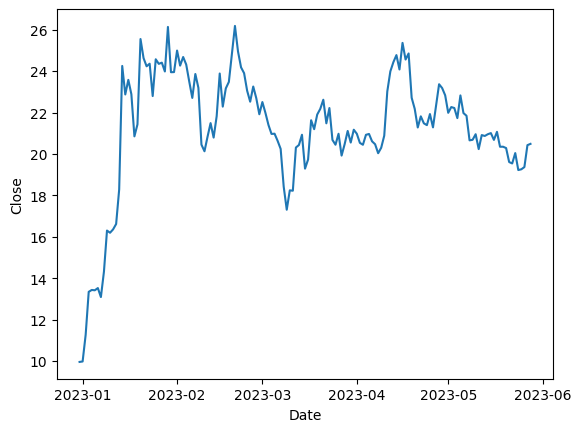

<Axes: xlabel='Date', ylabel='Variation'>

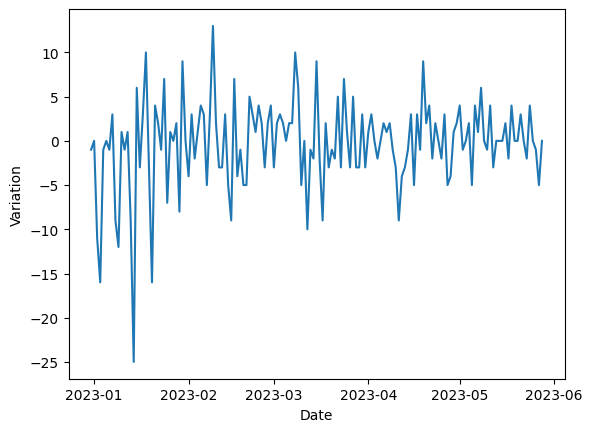

In [12]:
sns.lineplot(data,y='Close',x='Date')
plt.show()
sns.lineplot(data,y='Variation',x='Date')

<Axes: xlabel='Close', ylabel='Variation'>

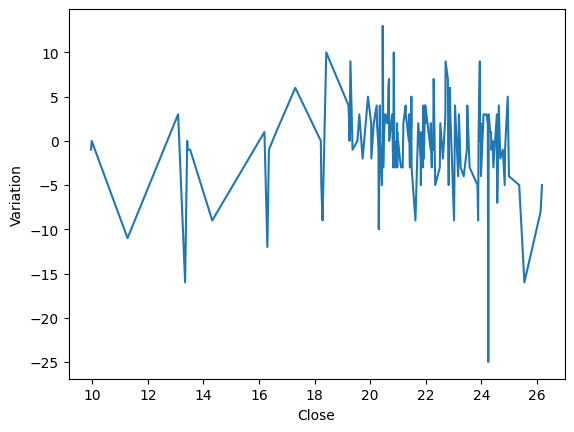

In [13]:
sns.lineplot(data,y='Variation',x='Close')

<Axes: xlabel='Volume', ylabel='Variation'>

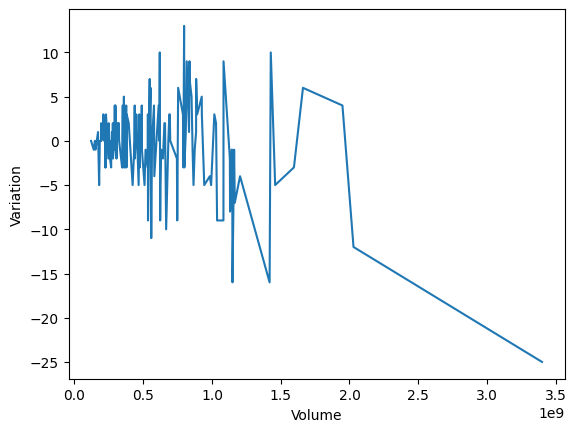

In [14]:
sns.lineplot(data,y='Variation',x='Volume')

<Axes: xlabel='Date', ylabel='Close'>

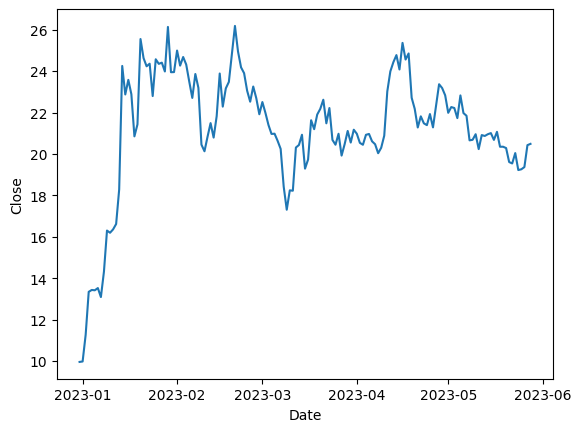

In [15]:
sns.lineplot(data,y='Close',x='Date')

### Preparing the strategy

In [16]:
data.drop(['Close','Date','Variation'],axis=1,inplace=True)

In [18]:
with open('sol_regressor','rb') as f:
    mod = pickle.load(f)

In [19]:
# This fonction calculate the percentage of the evolution of the price for a day
def pourcentage(open,close):
    return (close-open)/open*100

In [20]:
# Converting our dataset in a list and removing the date column
l = data.values.tolist()

### Strategy 

In [21]:
class strategie():
    def __init__(self, solde=100, limit= 0):
        self.gain =0
        self.pertes = 0
        self.solde = solde
        self.nb_achat = []
        self.limit = limit
    def achat(self, prix,valeur_btc):
        self.nb_achat.append({valeur_btc:prix})
        self.solde -= prix
    def pourcentage(open,close):
        return (close-open)/open*100
    def vente(self, prix_vente):
        d = self.nb_achat.pop(0)
        prix_achat=list(d.keys())[0]
        prix = d[prix_achat]
        self.solde += pourcentage(prix_achat,prix_vente)/100*prix+prix
        if pourcentage(prix_achat,prix_vente)/100*prix+prix > prix:
            self.gain += pourcentage(prix_achat,prix_vente)/100*prix
        else:
            self.pertes +=pourcentage(prix_achat,prix_vente)/100*prix
    def performences(self):
        print('gain: ',self.gain)
        print('pertes: ',self.pertes)
        print('solde: ',self.solde)
        print('nb_achat: ',self.nb_achat)
    def get_solde(self):
        return self.solde
    def get_nb_achat(self):    
        return len(self.nb_achat)
    def get_limit(self):
        return self.limit

In [74]:
def strategy(df,S):
    m = mod.predict(df)
    m = m.tolist()
    for i in range(len(m)):
        if S.get_solde == 0:
            return S.performences()
        if pourcentage(df.iloc[i][0],m[i]) <9  and S.get_solde() > S.get_limit():
            S.achat((15/100)*S.get_solde(),df.iloc[i][0])
        if pourcentage(df.iloc[i][0],m[i])>=10 and S.get_nb_achat()>0:
            S.vente(m[i])
    for i in range(S.get_nb_achat()):
        S.vente(m[-1])
    return S.performences()

In [75]:
S=strategie(100,6)
strategy(data,S)

gain:  51.18338428276428
pertes:  -9.126430234965385
solde:  142.05695404779888
nb_achat:  []
